Fitting 4 folds for each of 2 candidates, totalling 8 fits

✅ Best Parameters: {'class_weight': 'balanced', 'max_depth': 50, 'min_samples_split': 5, 'n_estimators': 250}

Cross-validation F1 scores: [0.94455899 0.94669764 0.9474791  0.94157346]
Mean CV score: 0.9451

📊 Validation Classification Report:
              precision    recall  f1-score   support

    Magnetic       0.95      0.97      0.96      7135
          NM       0.95      0.91      0.93      4107

    accuracy                           0.95     11242
   macro avg       0.95      0.94      0.94     11242
weighted avg       0.95      0.95      0.95     11242



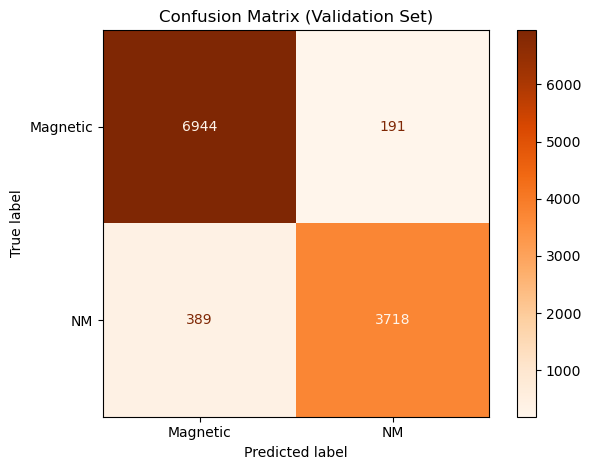

In [1]:
# Corrected RF with 4-fold CV

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# === 1. Load CSV ===
df = pd.read_csv("Materials_With_AtLeast_OneMagneticElement.csv")

# ===  Merge FM, FiM, and AFM into one class: Magnetic ===
df["ordering"] = df["ordering"].replace({"FM": "Magnetic", "FiM": "Magnetic", "AFM": "Magnetic"})

# === 2. Parse elements column: ['Element Fe', 'Element O'] → ['Fe', 'O'] ===
def parse_elements(val):
    if pd.isna(val):
        return []
    return [e.strip().split()[-1] for e in str(val).strip("[]").split(",")]

df["elements"] = df["elements"].apply(parse_elements)

# === 3. Extract crystal system from symmetry column ===
def extract_crystal_system(symmetry_str):
    if pd.isna(symmetry_str):
        return "Unknown"
    match = re.search(r"crystal_system=<CrystalSystem\.\w+: '(\w+)'", str(symmetry_str))
    return match.group(1) if match else "Unknown"

df["crystal_system"] = df["symmetry"].apply(extract_crystal_system)

# === 4. Drop rows with missing essential features ===
numerical_features = ["cbm", "vbm", "energy_above_hull", "band_gap", "density_atomic",
                      "numberofelements", "volume", "nsites", "density", "efermi", "formation_energy_per_atom"]
df = df.dropna(subset=numerical_features + ["ordering"])

# === 5. One-hot encode elements ===
mlb = MultiLabelBinarizer()
element_df = pd.DataFrame(mlb.fit_transform(df["elements"]), columns=mlb.classes_)

# === 6. One-hot encode crystal system ===
crystal_df = pd.get_dummies(df["crystal_system"], prefix="crysys")

# === 7. Combine all features ===
X = pd.concat([
    df[numerical_features].reset_index(drop=True),
    element_df.reset_index(drop=True),
    crystal_df.reset_index(drop=True)
], axis=1)

# === 8. Encode target ===
le = LabelEncoder()
y = le.fit_transform(df["ordering"])

# === 9. Split: 80% (train+val) and 20% (test) ===
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

# === 10. Split 80% into 60% (train) and 20% (val) ===
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# === 11. Setup CV and Grid Search ===
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

#using the best hyperparameters found for All Data Imported.csv dataset for time-related reasons.
param_grid = {
    'n_estimators': [250],
    'max_depth': [50],
    'min_samples_split': [5],
    'class_weight': ['balanced', None]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    scoring='f1_weighted',
    cv=skf,
    n_jobs=-1,
    verbose=1
)

# === 12. Fit on training set ===
grid_search.fit(X_train, y_train)
best_clf = grid_search.best_estimator_
print(f"\n✅ Best Parameters: {grid_search.best_params_}\n")

# === 13. Cross-validation scores on training set ===
cv_scores = cross_val_score(best_clf, X_train, y_train, cv=skf, scoring='f1_weighted', n_jobs=-1)
print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f}")

# === 14. Evaluate on validation set ===
print("\n📊 Validation Classification Report:")
y_pred_val = best_clf.predict(X_val)
print(classification_report(y_val, y_pred_val, target_names=le.classes_))

cm_val = confusion_matrix(y_val, y_pred_val)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=le.classes_)
disp_val.plot(cmap="Oranges", values_format="d")
plt.title("Confusion Matrix (Validation Set)")
plt.tight_layout()
plt.show()



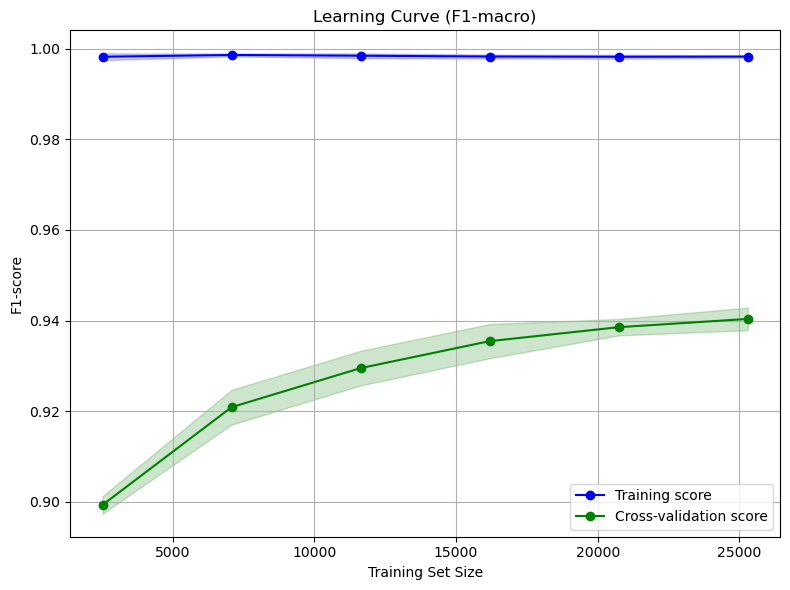

In [2]:
# Learning Curve Plot (Checking for overfitting)

from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# You already have this model
model = best_clf  # from GridSearchCV

train_sizes, train_scores, val_scores = learning_curve(
    model, X_train, y_train,
    train_sizes=np.linspace(0.1, 1.0, 6),  # from 10% to 100% of training data
    cv=4,
    scoring='f1_macro',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

# Compute means and standard deviations
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

train_std = np.std(train_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training score")
plt.plot(train_sizes, val_mean, 'o-', color="green", label="Cross-validation score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color="green")
plt.title("Learning Curve (F1-macro)")
plt.xlabel("Training Set Size")
plt.ylabel("F1-score")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


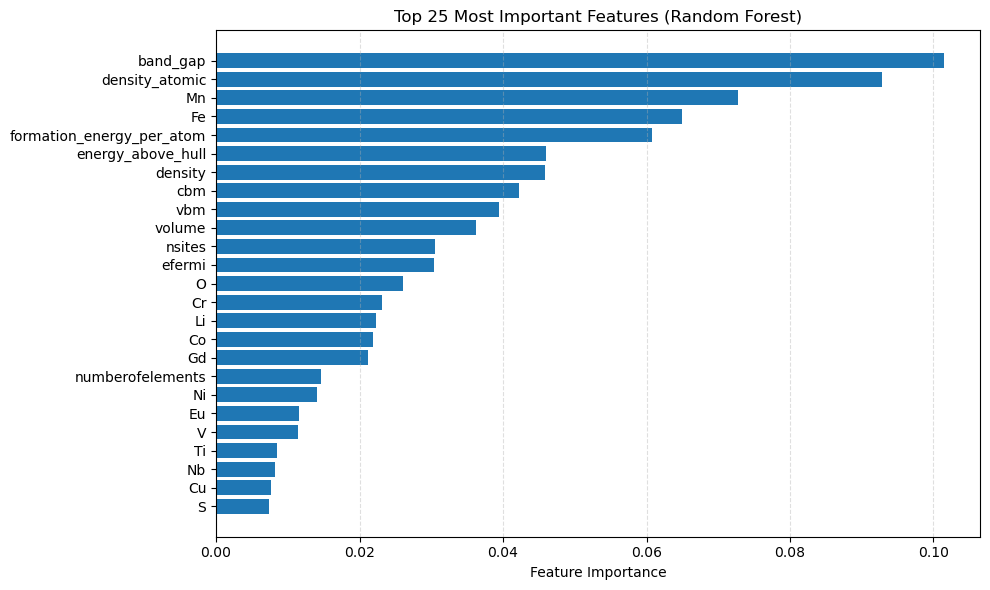

In [3]:
# === Extract individual feature importances ===
importances = best_clf.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
})

# === Sort by importance ===
top_n = 25  # adjust as needed
importance_df_sorted = importance_df.sort_values(by="Importance", ascending=False).head(top_n)

# === Plot top N features ===
plt.figure(figsize=(10, 6))
plt.barh(importance_df_sorted["Feature"][::-1], importance_df_sorted["Importance"][::-1])
plt.xlabel("Feature Importance")
plt.title(f"Top {top_n} Most Important Features (Random Forest)")
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.show()


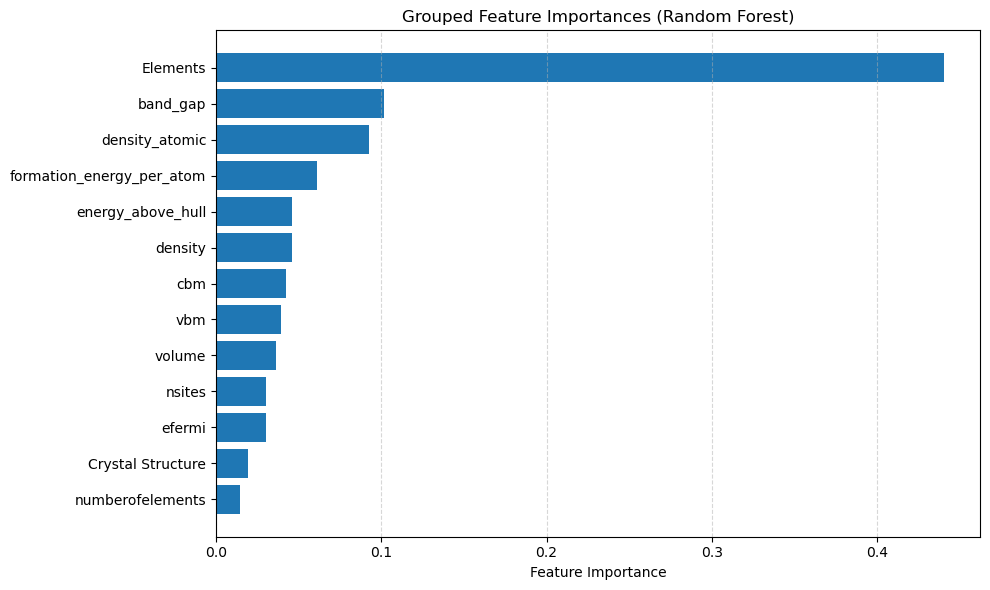

In [4]:
# === Feature groups reconstruction ===
num_features = df[numerical_features].columns.tolist()
element_features = element_df.columns.tolist()
crysys_features = crystal_df.columns.tolist()

# === Extract importances and assign groups ===
importances = best_clf.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
})

def categorize_feature(name):
    if name in num_features:
        return name  # keep as-is
    elif name in element_features:
        return "Elements"
    elif name in crysys_features:
        return "Crystal Structure"
    else:
        return "Other"

importance_df["Category"] = importance_df["Feature"].apply(categorize_feature)

# === Group: sum Elements and Crystal Structure, keep numerical ===
grouped_df = importance_df.groupby("Category")["Importance"].sum().reset_index()
grouped_df = grouped_df.sort_values(by="Importance", ascending=False)

# === Plot ===
plt.figure(figsize=(10, 6))
plt.barh(grouped_df["Category"][::-1], grouped_df["Importance"][::-1])
plt.xlabel("Feature Importance")
plt.title("Grouped Feature Importances (Random Forest)")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
